In [7]:
!pip3 install matplotlib pandas seaborn numpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try brew install
    xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a Python library that isn't in Homebrew,
    use a virtual environment:
    
    python3 -m venv path/to/venv
    source path/to/venv/bin/activate
    python3 -m pip install xyz
    
    If you wish to install a Python application that isn't in Homebrew,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. You can install pipx with
    
    brew install pipx
    
    You may restore the old behavior of pip by passing
    the '--break-system-packages' flag to pip, or by adding
    'break-system-packages = true' to your pip.conf file. The latter
    will permanently disable this error.
    
    If you disable this error, we STRONGLY recommend that you additionally
    pass the '--user' flag to pip, or set 

In [17]:
associations_df = pd.read_csv("data/associations_df.csv")
lp_schedule = pd.read_csv("schedules/milp_green.csv")
# lp_schedule = lp_schedule.drop(columns=['idx'])
greedy_green_schedule = pd.read_csv("schedules/green_case.csv")
greedy_green_schedule = greedy_green_schedule.drop(columns=['idx'])
worst_case_greedy_schedule = pd.read_csv("schedules/worst_case.csv")
worst_case_greedy_schedule = worst_case_greedy_schedule.drop(columns=['idx'])
basic_schedule = pd.read_csv("schedules/basic_planner.csv")
random_schedule = pd.read_csv("schedules/random_schedule.csv")
print(associations_df.columns)
print(associations_df['forecast_id'].unique())

Index(['node', 'job_id', 'forecast_id', 'transfer_time', 'throughput',
       'host_joules', 'link_joules', 'total_joules', 'avg_ci',
       'carbon_emissions'],
      dtype='object')
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


In [14]:
def visualize_job_carbon_intensity(associations_df, job_id):
    # Filter for the specified job
    job_df = associations_df[associations_df['job_id'] == job_id]

    # Pivot the data for heatmap format
    heatmap_data = job_df.pivot(index='node', columns='forecast_id', values='carbon_emissions')

    # Define color map
    cmap = mcolors.LinearSegmentedColormap.from_list("carbon_intensity_cmap", ["green", "yellow", "red"])
    norm = mcolors.Normalize(vmin=job_df['carbon_emissions'].min(), vmax=job_df['carbon_emissions'].max())

    # Plot with automatic contrasting text colors
    plt.figure(figsize=(15, 6))
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        norm=norm,
        annot=True,
        fmt=".1f",
        annot_kws={'color': 'black', 'weight': 'bold'},  # Set font properties
        cbar_kws={'label': 'Carbon Emissions (gCO2eq)'},
        linewidths=0.5,
        linecolor='black'
    )

    plt.xlabel('Forecast ID (Time Slot)', fontweight='bold')
    plt.ylabel('Node', fontweight='bold')
    plt.title(f'Carbon Emissions Heatmap for Job {job_id}', fontweight='bold', pad=20)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [15]:
def visualize_schedule(schedule_df, associations_df, name):
    # Get unique nodes and time slots (forecast_id) from associations_df
    nodes = associations_df['node'].unique()
    time_slots = sorted(associations_df['forecast_id'].unique())  # Use all unique time slots from associations_df

    # Create a grid of all nodes and time slots
    grid_df = pd.DataFrame([(node, t) for node in nodes for t in time_slots], columns=['node', 'forecast_id'])

    # Merge with schedule_df to get job assignments
    grid_df = grid_df.merge(
        schedule_df[['node', 'forecast_id', 'job_id', 'carbon_emissions']],
        on=['node', 'forecast_id'],
        how='left'
    )

    # Fill NaN job_id with -1 (no job scheduled) and NaN carbon_emissions with 0
    grid_df['job_id'] = grid_df['job_id'].fillna(-1)
    grid_df['carbon_emissions'] = grid_df['carbon_emissions'].fillna(0)

    # Aggregate data for each node and forecast_id
    aggregated_df = grid_df.groupby(['node', 'forecast_id'], as_index=False).agg({
        'job_id': lambda x: ', '.join(map(str, x[x != -1])) if any(x != -1) else '-1',  # Combine job IDs
        'carbon_emissions': 'sum'  # Sum carbon emissions
    })

    # Pivot the grid to create a heatmap-friendly format
    heatmap_data = aggregated_df.pivot(index='node', columns='forecast_id', values='carbon_emissions')
    job_data = aggregated_df.pivot(index='node', columns='forecast_id', values='job_id')

    # Define a color map for carbon emissions (green to red)
    cmap = mcolors.LinearSegmentedColormap.from_list("emissions_cmap", ["green", "red", "brown"])
    norm = mcolors.Normalize(vmin=associations_df['carbon_emissions'].min(),
                             vmax=associations_df['carbon_emissions'].max())

    # Plot the heatmap
    plt.figure(figsize=(15, 6))
    sns.heatmap(
        heatmap_data,
        cmap=cmap,  # Color map for carbon emissions
        norm=norm,  # Normalize emissions values
        annot=job_data,  # Show job IDs in cells
        fmt="",  # No special formatting for annotations
        cbar_kws={'label': 'Carbon Emissions'},
        linewidths=0.5,
        linecolor='black',
        mask=(job_data == '-1')  # Mask empty slots
    )

    # Customize the plot
    plt.xlabel('Forecast ID (Time Slot)')
    plt.ylabel('Node')
    plt.title(f'Job Schedule Heatmap - Colored by Carbon Emissions using {name}')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

MILP Programming created a total emissions of 2891.2813835607208
Greedy Carbon Min created a total emissions of 3600.7924654999997
Greedy Carbon Max  created a total emissions of 5307.837339050926
Basic Case created a total emissions of 5298.105529796653
Random Case created a total emissions of 5992.441263375515


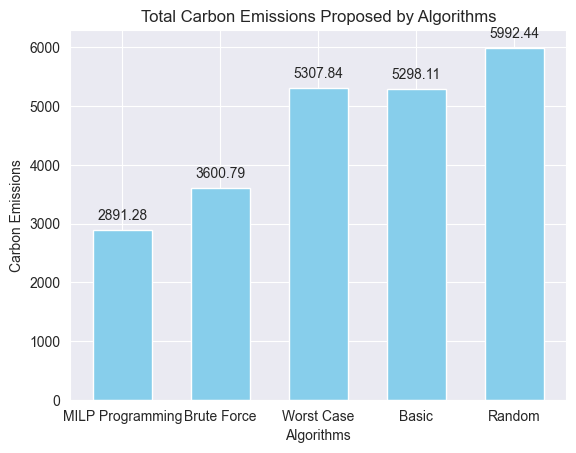

In [19]:
def total_emissions_schedule(schedule_df, schedule_name):
    total = schedule_df['carbon_emissions'].sum()
    print(f"{schedule_name} created a total emissions of {schedule_df['carbon_emissions'].sum()}")
    return total


# Calculate total emissions for each schedule
lp_total_ce = total_emissions_schedule(lp_schedule, "MILP Programming")
brute_total_ce = total_emissions_schedule(greedy_green_schedule, "Greedy Carbon Min")
worst_total_ce = total_emissions_schedule(worst_case_greedy_schedule, "Greedy Carbon Max ")
basic_total_ce = total_emissions_schedule(basic_schedule, "Basic Case")
random_total_ce = total_emissions_schedule(random_schedule, "Random Case")

# List of total emissions
total_ce_list = [lp_total_ce, brute_total_ce, worst_total_ce, basic_total_ce, random_total_ce]

# Plotting the bar graph
plt.bar(["MILP Programming", "Brute Force", "Worst Case", "Basic", "Random"], total_ce_list, color='skyblue', width=0.6)
plt.xlabel("Algorithms")
plt.ylabel("Carbon Emissions")
plt.title("Total Carbon Emissions Proposed by Algorithms")

# Add values on top of each bar
for i, value in enumerate(total_ce_list):
    plt.text(i, value + 0.02 * max(total_ce_list), f"{value:.2f}", ha='center', va='bottom')

plt.show()

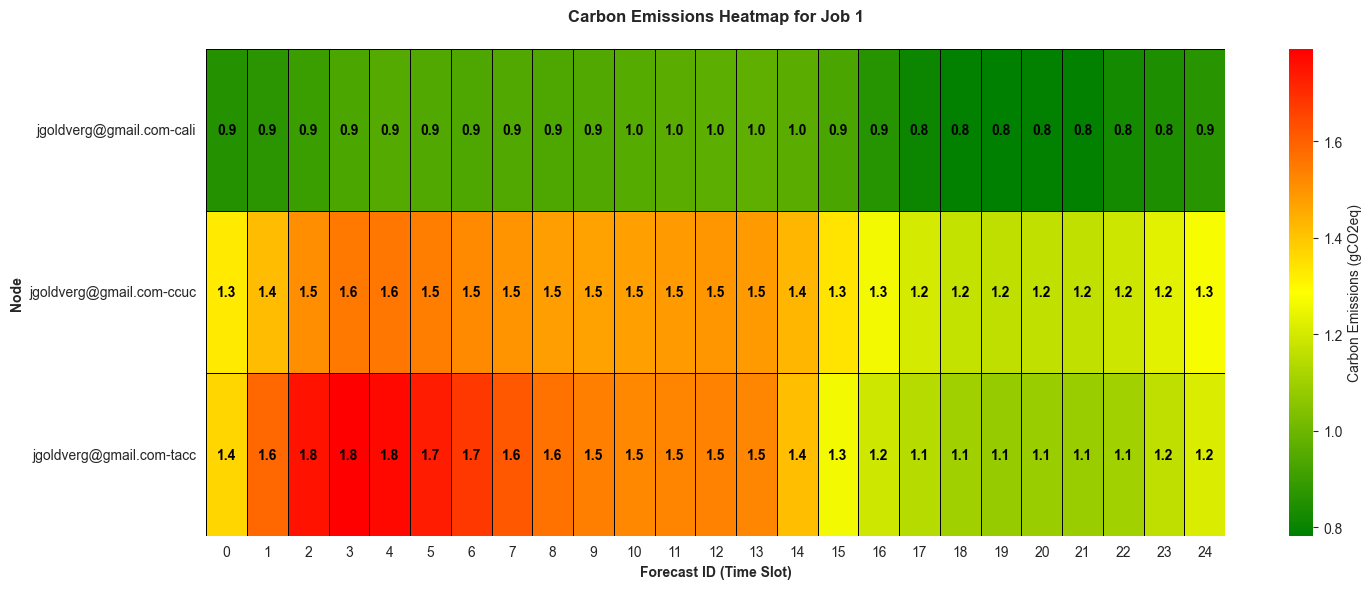

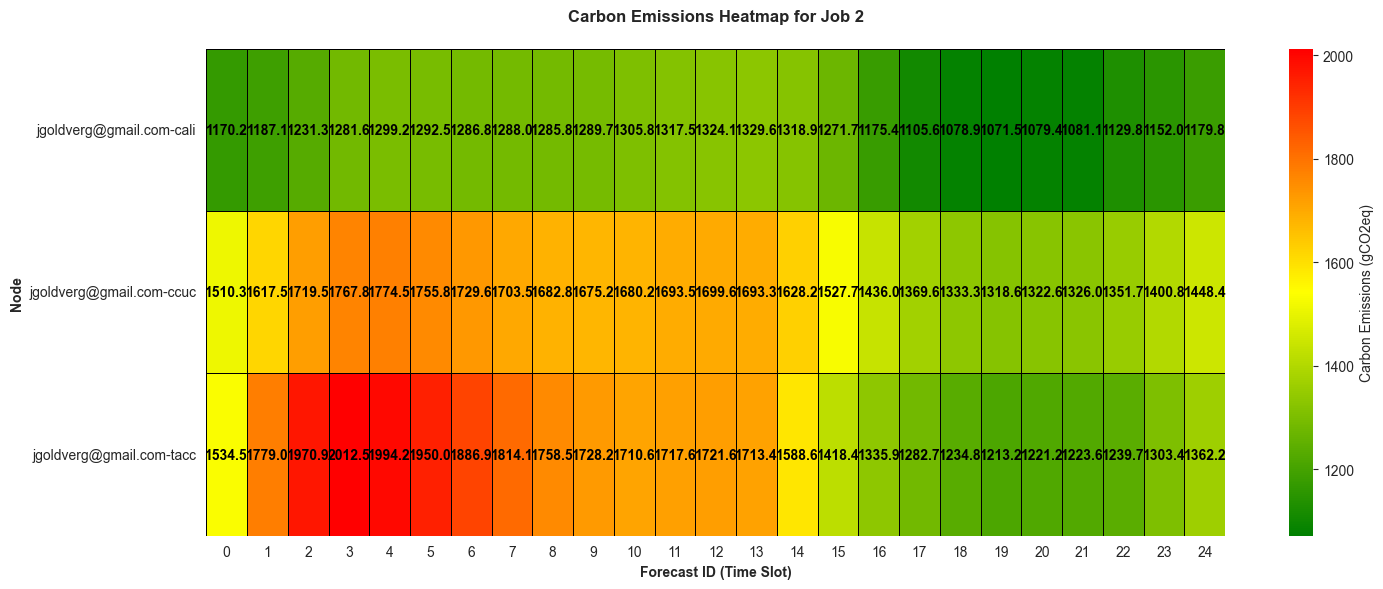

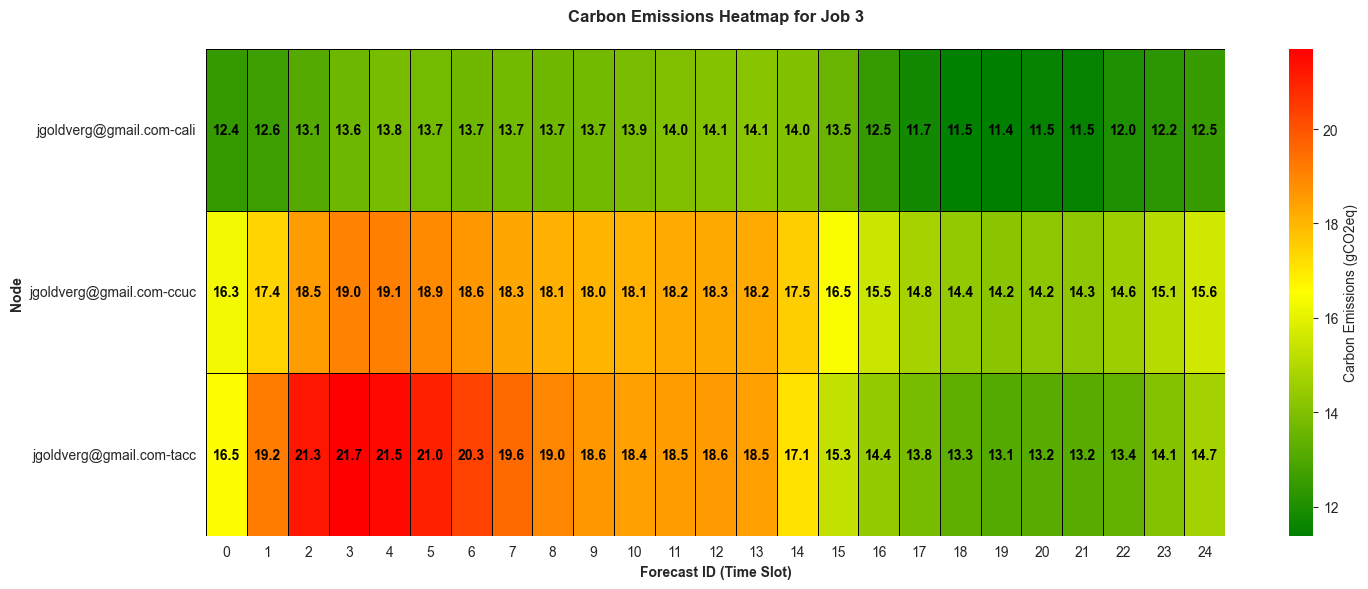

In [20]:
visualize_job_carbon_intensity(associations_df, 1)
visualize_job_carbon_intensity(associations_df, 2)
visualize_job_carbon_intensity(associations_df, 3)

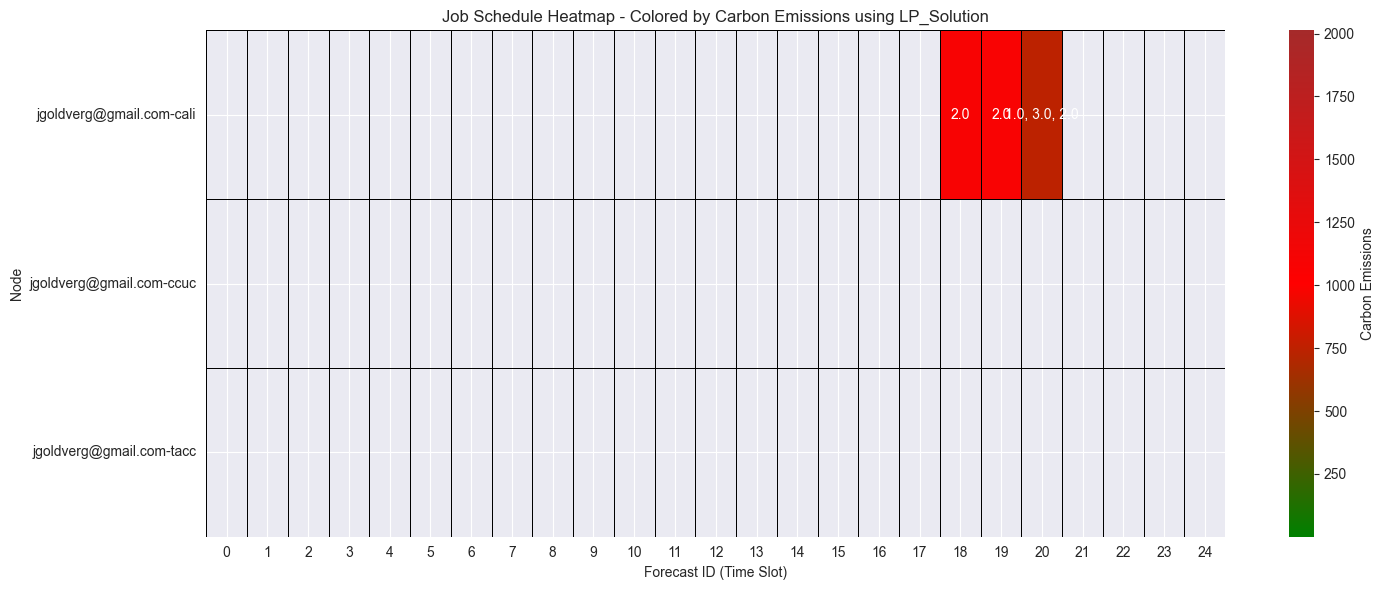

In [21]:
visualize_schedule(lp_schedule, associations_df,  "LP_Solution")


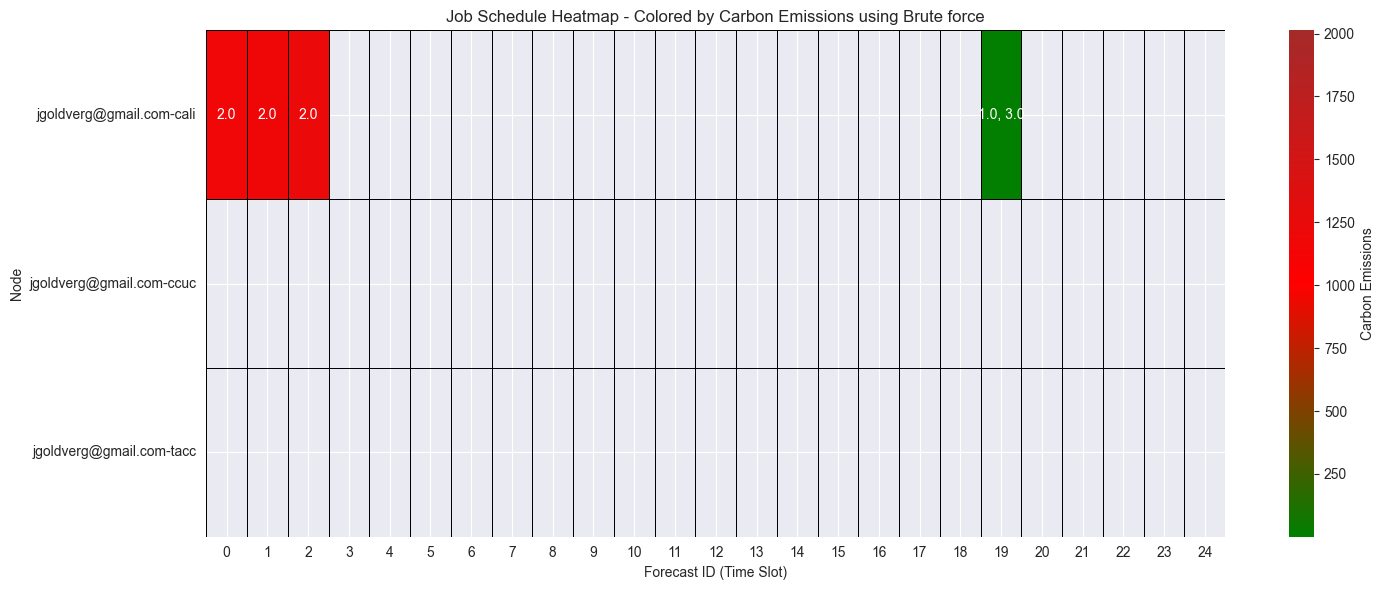

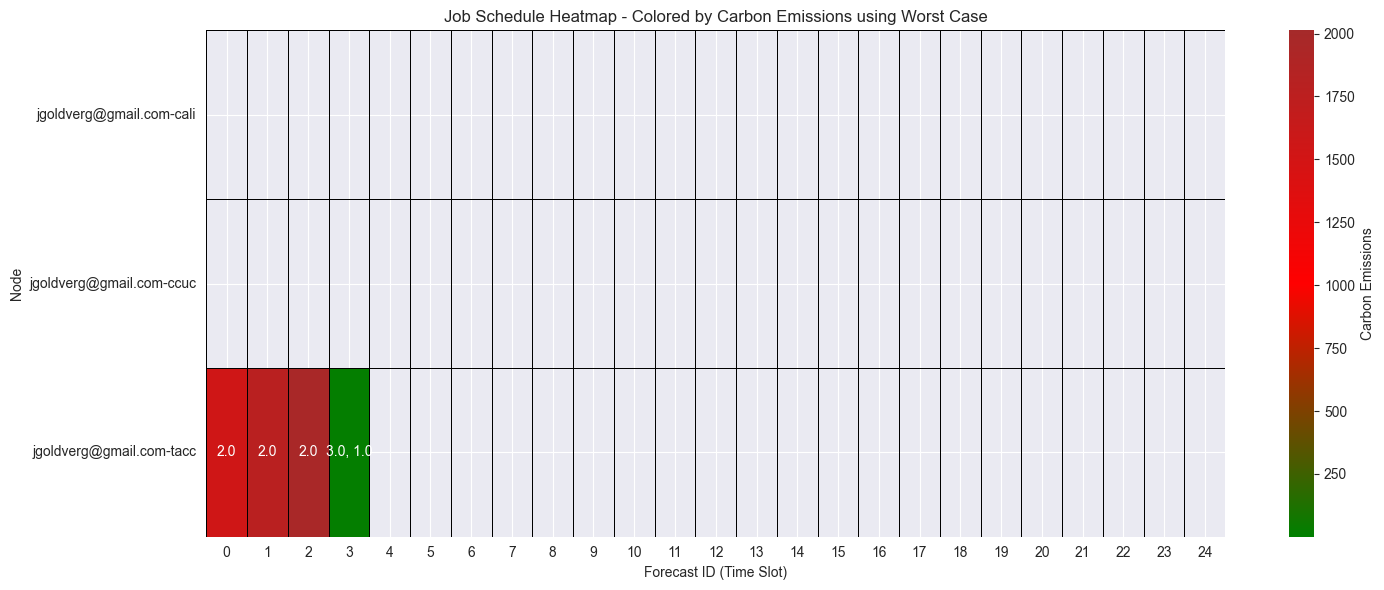

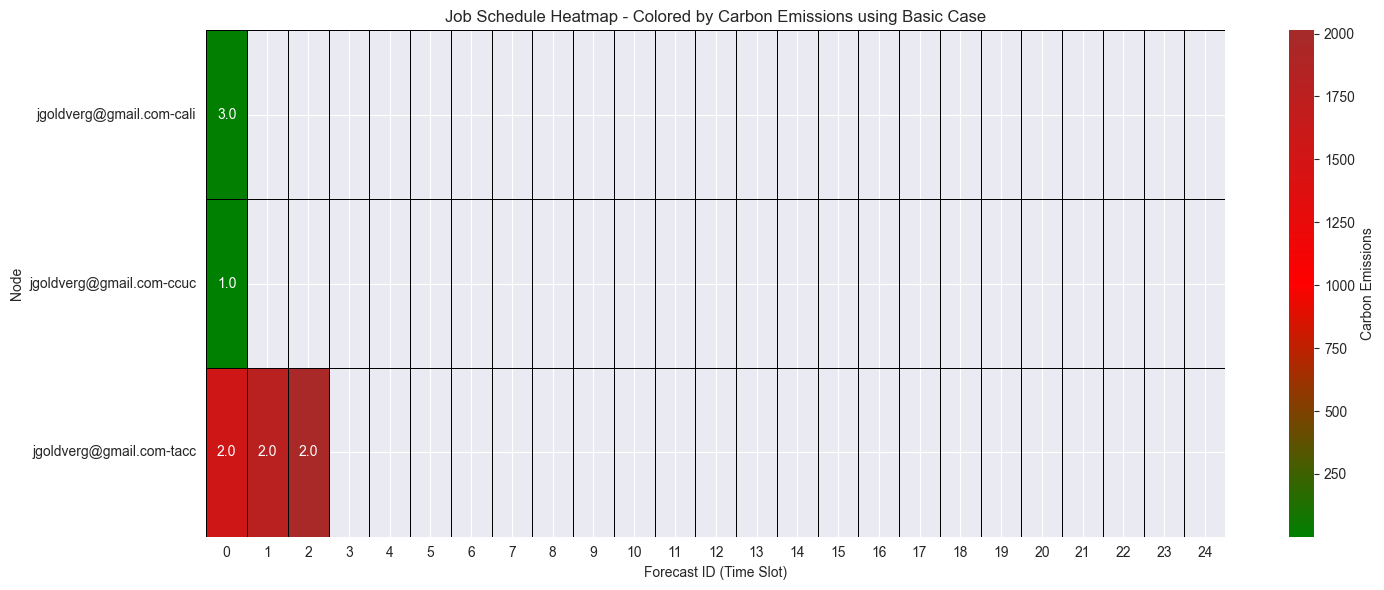

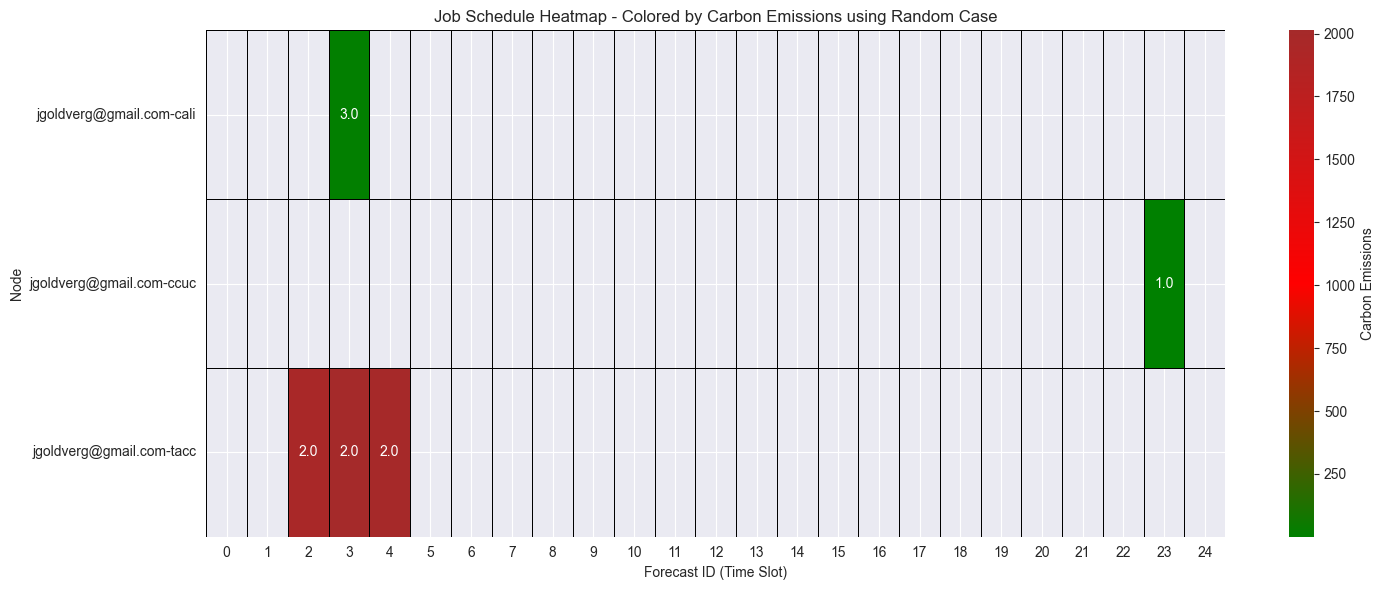

In [22]:
visualize_schedule(greedy_green_schedule, associations_df, "Brute force")
visualize_schedule(worst_case_greedy_schedule, associations_df, "Worst Case")
visualize_schedule(basic_schedule, associations_df, "Basic Case")
visualize_schedule(random_schedule, associations_df, "Random Case")